In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [80]:
import pandas as pd
import os
import json
import re
import scipy as sp
import pickle

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import faiss
from sklearn.metrics import mean_squared_error, mean_absolute_error

import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(1234)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:
#! pip install faiss-cpu

## Problem Statement

Given a user, predict the similar restaurants matching with user profile

- User Profile : Average of Reviews Given by a User
- Business Profile : Average of all Reviews received by a restaurant

How to handle the cold start problem

- If the user is not in the user profile database, start with the average  user profiles of all the users

**Experiments**

- Split Data Randomly
- Split Data based on Unique Users only
- Split Data based on Unique Restaurants

In [3]:
base_dir = '/content/gdrive/MyDrive/MLDS/Data_Mining/Project'
data_dir = os.path.join(base_dir, 'data')
os.listdir(data_dir)

['process_user_business_data_v1.json',
 'svd_400_tfidf_matrix_v1.npy',
 'filtered_small_df_v1.json',
 'tfidf_matrix_small_v1.npz',
 'tfidf_vectorizer_small_v1.pk',
 'svd_500_tfidf_matrix_small_v1.npy',
 'user_profiles_v1.json',
 'user_profiles_v1.pkl']

In [4]:
# data = pd.read_json(os.path.join(data_dir,'process_user_business_data_v1.json'))
# print(data.shape)

In [6]:
#data.head(2)

In [ ]:
## The dataset is quite large to be worked on CPU. So, taking randomly sampling the data
user_data = data.groupby('user_id')['review_id'].count().sort_values(ascending=False).reset_index()
user_data.rename(columns = {'review_id' : 'review_count'}, inplace=True)
user_data.head(2)

,user_id,review_count
0,_BcWyKQL16ndpBdggh2kNA,1397
1,ET8n-r7glWYqZhuR6GcdNw,1282


In [ ]:
# Filtering based on User
print("Original Data:",data.shape[0])
print("Unique Users:",user_data.shape[0])
user_review_threshold = 20 # Review Count Threshold
filtered_user_ids = user_data[user_data.review_count >= user_review_threshold]['user_id']
print("Filtered Users:",len(filtered_user_ids))

filtered_data = data[data.user_id.isin(filtered_user_ids)]
print("Filterd Data:",filtered_data.shape[0])

Original Data: 967327
Unique Users: 279827
Filtered Users: 6395
Filterd Data: 339222


In [ ]:
# Filtering User Reviews

user_review_threshold = 500

lv2_filtered_df = pd.DataFrame(columns=filtered_data.columns)
for user_id, user_df in tqdm(filtered_data.groupby('user_id')):
  sample_count = min(user_df.shape[0], user_review_threshold)
  sampled_df = user_df.sample(n=sample_count)
  lv2_filtered_df = pd.concat([lv2_filtered_df, sampled_df])

print(lv2_filtered_df.shape)

100%|██████████| 6395/6395 [21:12<00:00,  5.03it/s]

(336389, 22)


In [ ]:
print(lv2_filtered_df.shape)

(336389, 22)


In [ ]:
lv2_filtered_df.to_json(os.path.join(data_dir, 'filtered_small_df_v1.json'))

In [7]:
lv2_filtered_df = pd.read_json(os.path.join(data_dir, 'filtered_small_df_v1.json'))

In [8]:
cols_to_use = ['user_id', 'business_id', 'text', 'stars_y']

restaurant_reviews = lv2_filtered_df[cols_to_use]

restaurant_reviews.rename(columns={'stars_y' : 'rating'}, inplace=True)

In [9]:
restaurant_reviews.head(2)

,user_id,business_id,text,rating
198656,-1MF2tosrw2WcCxeVNk81Q,EJ7Tp_KdGx52wSu0_7gbEQ,Went to see Shen Yun which left me in awe of w...,2.5
828838,-1MF2tosrw2WcCxeVNk81Q,qFwKNXKt2fvCatrLAqDONg,Piece of junk restaurant. The whole point of t...,2.0


In [10]:
restaurant_reviews.rating.max()

5.0

In [ ]:
def clean_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Remove digits
    text = re.sub(r'\d', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = text.strip()
    return text

def tokenize_text(text):
    return word_tokenize(text)

def process_reviews(document):
    cleaned_text = tokenize_text(clean_text(document))
    cleaned_text = ' '.join(cleaned_text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text

In [ ]:
# Applying Text Cleaning to all data ! Will be useful for creating user profiles
restaurant_reviews['processed_text'] = restaurant_reviews['text'].apply(lambda x : process_reviews(x))
restaurant_reviews.head()

,user_id,business_id,text,rating,processed_text
198656,-1MF2tosrw2WcCxeVNk81Q,EJ7Tp_KdGx52wSu0_7gbEQ,Went to see Shen Yun which left me in awe of w...,2.5,went to see shen yun which left me in awe of w...
828838,-1MF2tosrw2WcCxeVNk81Q,qFwKNXKt2fvCatrLAqDONg,Piece of junk restaurant. The whole point of t...,2.0,piece of junk restaurant the whole point of th...
781878,-1MF2tosrw2WcCxeVNk81Q,A4CPH0tLHOrtoTVNQcJSRQ,This place is far inferior compared to Hong Ko...,2.5,this place is far inferior compared to hong ko...
918436,-1MF2tosrw2WcCxeVNk81Q,owwOC1bVQt1XAMdiM1TOzw,"For an airport cafe, this place is pretty dece...",2.0,for an airport cafe this place is pretty decen...
507130,-1MF2tosrw2WcCxeVNk81Q,838bEDzZSPveDkAGrhVWYQ,Absolutely amazing and authentic Chinese/Hong ...,3.0,absolutely amazing and authentic chinesehong k...


In [ ]:
restaurant_reviews.shape[0]

336389

In [ ]:
tfidf_params = {
    "min_df" : 0.01, # terms that appear in less than 1% of the documents
    "max_features" : 10000, # keep the most frequent 10000 terms
    "smooth_idf" : True,    # adds one to document frequencies
    "sublinear_tf" : True,  # apply sublinear tf scaling
    "norm" : 'l2',          # L2-normalize vectors
    "use_idf" : True,       # enable IDF reweighting
    "ngram_range" : (1, 2)  # include both unigrams and bigrams
}
tfidf_vectorizer = TfidfVectorizer(**tfidf_params)
tfidf_matrix = tfidf_vectorizer.fit_transform(restaurant_reviews['processed_text'])
tfidf_matrix.shape

(336389, 2211)

In [11]:
# Saving TFIDF Matrix
#sp.sparse.save_npz(os.path.join(data_dir,'tfidf_matrix_small_v1.npz'), tfidf_matrix)

# Sample loading code
tfidf_matrix = sp.sparse.load_npz(os.path.join(data_dir,'tfidf_matrix_small_v1.npz'))

In [ ]:
with open(os.path.join(data_dir,'tfidf_vectorizer_small_v1.pk'), 'wb') as fin:
    pickle.dump(tfidf_vectorizer, fin)

#tfidf_vectorizer = pickle.load(open(os.path.join(data_dir,'tfidf_vectorizer_v1.pk'), 'rb'))

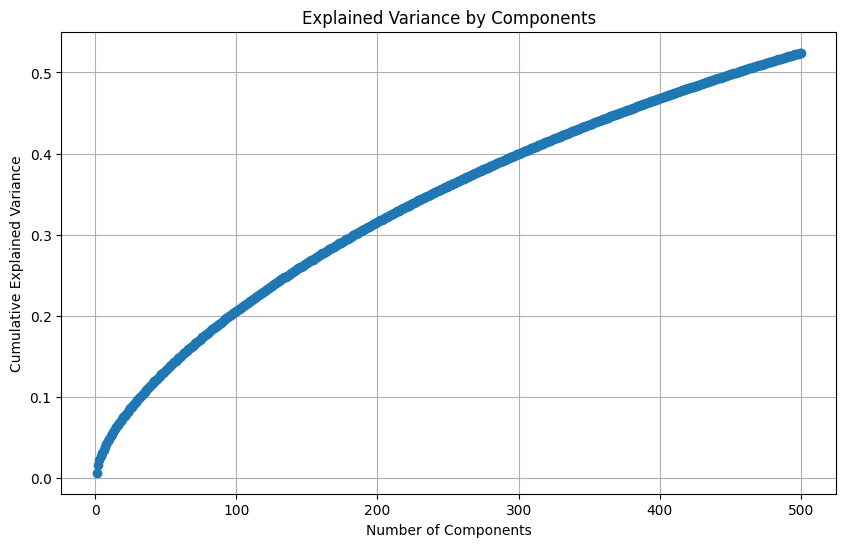

In [ ]:
# Since the matrices are very large in dimension and also sparse in nature , Lets reduce the dimensions using SVD
svd = TruncatedSVD(n_components=500)  # Use n-1 components to explore variance
tfidf_reducded = svd.fit_transform(tfidf_matrix)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

In [12]:
del tfidf_matrix
#del data
del lv2_filtered_df

In [ ]:
np.save(os.path.join(data_dir,'svd_500_tfidf_matrix_small_v1.npy'), tfidf_reducded)

In [13]:
tfidf_reducded = np.load(os.path.join(data_dir,'svd_500_tfidf_matrix_small_v1.npy'))

In [14]:
profile_arr = tfidf_reducded.tolist()

In [15]:
restaurant_reviews['profiles'] = profile_arr

In [16]:
user_groups = restaurant_reviews.groupby('user_id')
user_profiles = {}
for usergrp in tqdm(user_groups):
    profiles = np.array([np.array(profile) for profile in np.array(usergrp[1]['profiles'])])
    mean_profile = np.mean(profiles,axis=0)
    user_profiles[usergrp[0]] = mean_profile

100%|██████████| 6395/6395 [00:12<00:00, 500.09it/s]


In [17]:
with open(os.path.join(data_dir, 'user_profiles_v1.pkl'), 'wb') as f:
  pickle.dump(user_profiles, f)

In [18]:
item_groups = restaurant_reviews.groupby('business_id')
item_profiles = {}
for itemrgrp in tqdm(item_groups):
    profiles = np.array([np.array(profile) for profile in np.array(itemrgrp[1]['profiles'])])
    mean_profile = np.mean(profiles,axis=0)
    item_profiles[itemrgrp[0]] = mean_profile

100%|██████████| 13408/13408 [00:17<00:00, 771.23it/s] 


In [19]:
with open(os.path.join(data_dir, 'item_profiles_v1.pkl'), 'wb') as f:
  pickle.dump(item_profiles, f)

## Experiment 1

__Splitting Data at Random__

In [22]:
def split_randomly(df, split_dict = {'train' : 0.7, 'test' : 0.3}):
  df_copy = df.copy()

  train_count = int(split_dict['train'] * df_copy.shape[0])
  test_count = df_copy.shape[0] - train_count

  train_test_list = ['train'] * train_count + ['test'] * test_count
  random.shuffle(train_test_list)

  df_copy['train_type'] = train_test_list
  return df_copy

In [25]:
df_random_split = split_randomly(df = restaurant_reviews)
df_random_split.head(2)

,user_id,business_id,text,rating,profiles,train_type
198656,-1MF2tosrw2WcCxeVNk81Q,EJ7Tp_KdGx52wSu0_7gbEQ,Went to see Shen Yun which left me in awe of w...,2.5,"[0.29518131158077493, 0.059643589824464056, 0....",train
828838,-1MF2tosrw2WcCxeVNk81Q,qFwKNXKt2fvCatrLAqDONg,Piece of junk restaurant. The whole point of t...,2.0,"[0.18743627709081329, -0.013925447136043715, 0...",test


In [27]:
df_train = df_random_split[df_random_split.train_type == 'train']
df_test  = df_random_split[df_random_split.train_type == 'test']

print(df_train.shape, df_test.shape)

(235472, 6) (100917, 6)


In [28]:
# Checking if any completely new user is there in the test set
for user_id in df_test.user_id.unique():
  if user_id not in df_train.user_id.unique():
    print(user_id)

In [29]:
# Now top similar recommendations can be found in two ways
# Find Similar Recommendations from the restaurants that user has already rated
# Find Similar Recommendations based on the User Profile and all the business Profiles. This will give surprise recommendations as well

In [83]:
# Finding Surprise Recommendations
def create_business_profile_database(business_profiles):
  business_ids = list(business_profiles.keys())
  business_tfidf = np.array(list(business_profiles.values()))

  idx2business = {idx: business_id for idx, business_id in enumerate(business_ids)}

  normalized_business_tfidf =  business_tfidf / np.linalg.norm(business_tfidf, axis=1)[:, np.newaxis]

  dimension = normalized_business_tfidf.shape[1]
  index = faiss.IndexFlatIP(dimension)  # IndexFlatIP uses inner product (equivalent to cosine similarity for normalized vectors)

  index.add(normalized_business_tfidf.astype('float32'))  # FAISS expects vectors to be in float32 format
  return index, idx2business

class SurpriseContentBasePredictor:
  """It will generate surprise/new recommendations that user may/may not have visited"""
  def __init__(self, index, idx2business, user_profiles, train_data):
    self.db_index = index
    self.idx2business = idx2business
    self.user_profiles = user_profiles
    self.train_data = train_data

  def findTopkRecommendations(self, user_profile, topk=5):
    user_profile = np.array([user_profile])
    normalized_user_profile = user_profile / np.linalg.norm(user_profile, axis=1)[:, np.newaxis]
    D, I = self.db_index.search(normalized_user_profile.astype('float32'), topk)

    recommended_business_ids = [self.idx2business[idx] for idx in I[0]]
    return recommended_business_ids

  def predict_rating(self, business_ids):
    recommended_rating = self.train_data[self.train_data.business_id.isin(business_ids)]['rating'].mean()
    return recommended_rating


  def predict(self, userId, topk=5):
    user_profile = self.user_profiles.get(userId, None)
    if user_profile is None:
      # Start with Average User Profile
      user_profile = np.array(list(user_profiles.values())).mean(axis=0)

    topk_recommendations = self.findTopkRecommendations(user_profile, topk)
    predicted_rating = self.predict_rating(business_ids=topk_recommendations)
    return {'rating' : predicted_rating, 'business_ids' : topk_recommendations}

In [84]:
# Creating DB Index
db_index, idx2business = create_business_profile_database(business_profiles=item_profiles)


# Creating Train User Profiles
train_user_ids = df_train.user_id.unique()
user_profile_df = pd.DataFrame({
    "user_id" : list(user_profiles.keys()),
    "profile" : list(user_profiles.values())
})
train_user_profiles = user_profile_df[user_profile_df.user_id.isin(train_user_ids)].set_index('user_id').to_dict()['profile']


surp_CBR = SurpriseContentBasePredictor(index=db_index,
                                        idx2business=idx2business,
                                        user_profiles=train_user_profiles,
                                        train_data=df_train
                                        )

In [85]:
def evaluate_CBR(df_test, topk):
  unique_users = df_test.user_id.unique()
  print("Users in Test Set :",len(unique_users))

  print("Extracting GT Ratings")
  gt_ratings = [df_test[df_test.user_id == user].rating.mean() for user in unique_users]
  predicted_ratings = []
  print("Startig Prediction")
  for user_id in tqdm(unique_users):
    preds = surp_CBR.predict(userId = user_id, topk=topk)
    predicted_ratings.append(preds.get('rating'))

  mse = mean_squared_error(gt_ratings, predicted_ratings)
  mae = mean_absolute_error(gt_ratings, predicted_ratings)
  print(f"mse@k={topk} : {mse}, mae@k={topk} : {mae}")
  print("Done")
  return mse, mae

In [86]:
evaluate_CBR(df_test, topk=5)

Users in Test Set : 6394
Extracting GT Ratings
Startig Prediction


100%|██████████| 6394/6394 [03:20<00:00, 31.92it/s]

mse@k=5 : 0.1711278910288091, mae@k=5 : 0.30892226747549206
Done


(0.1711278910288091, 0.30892226747549206)

In [87]:
topk_list = [2, 4, 5, 10, 15, 20]
mse_list = []
mae_list = []
for topk in topk_list:
  mse, mae = evaluate_CBR(df_test, topk=topk)
  mse_list.append(mse)
  mae_list.append(mae)

Users in Test Set : 6394
Extracting GT Ratings
Startig Prediction


100%|██████████| 6394/6394 [01:58<00:00, 53.83it/s]


mse@k=2 : 0.266977816730063, mae@k=2 : 0.38901801373344375
Done
Users in Test Set : 6394
Extracting GT Ratings
Startig Prediction


100%|██████████| 6394/6394 [02:13<00:00, 47.87it/s]


mse@k=4 : 0.19101624171257303, mae@k=4 : 0.326677020646582
Done
Users in Test Set : 6394
Extracting GT Ratings
Startig Prediction


100%|██████████| 6394/6394 [02:38<00:00, 40.29it/s]


mse@k=5 : 0.1711278910288091, mae@k=5 : 0.30892226747549206
Done
Users in Test Set : 6394
Extracting GT Ratings
Startig Prediction


100%|██████████| 6394/6394 [02:59<00:00, 35.59it/s]


mse@k=10 : 0.13018259420133702, mae@k=10 : 0.27122370144818764
Done
Users in Test Set : 6394
Extracting GT Ratings
Startig Prediction


100%|██████████| 6394/6394 [02:33<00:00, 41.72it/s]


mse@k=15 : 0.11054030750193969, mae@k=15 : 0.2524034719999385
Done
Users in Test Set : 6394
Extracting GT Ratings
Startig Prediction


100%|██████████| 6394/6394 [03:15<00:00, 32.76it/s]

mse@k=20 : 0.09978209044589734, mae@k=20 : 0.24120054226383988
Done


Text(0.5, 1.0, 'MSE vs TopK')

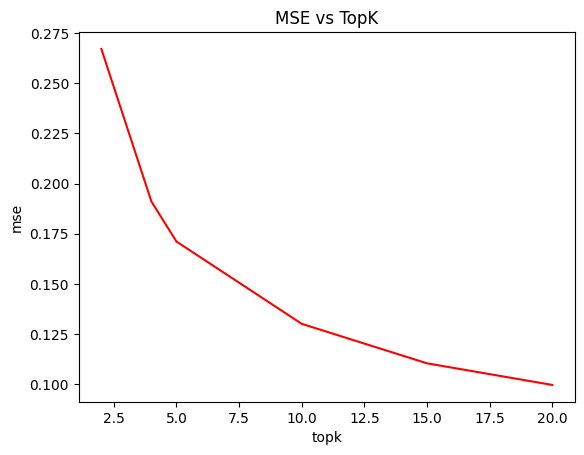

In [94]:
plt.plot(topk_list, mse_list, color='r')
plt.xlabel('topk')
plt.ylabel('mse')
plt.title('MSE vs TopK')

Text(0.5, 1.0, 'MAE vs TopK')

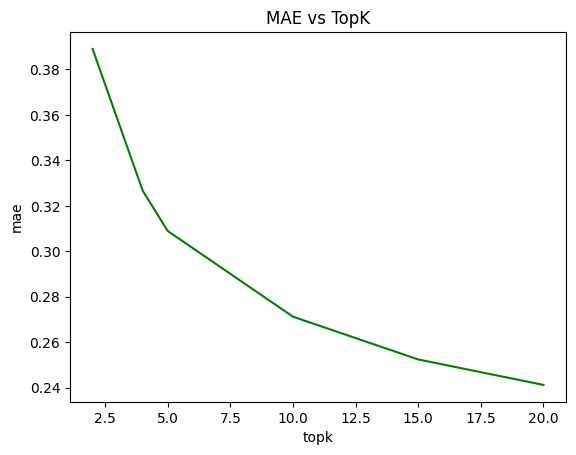

In [95]:
plt.plot(topk_list, mae_list, color='g')
plt.xlabel('topk')
plt.ylabel('mae')
plt.title('MAE vs TopK')

## Experiment 2

__Splitting based on ItemId, the test set ItemID will not be present in the trainset